This code generates a fake set of flare data. 

Output:
- Flare_times (A dataframe with the time stamp of each flare and energy)
- Time_series (An array with a total observing time T)

In [1]:
# --- Standard Library ---

import math

# --- Third-Party Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager as fm
from astropy.io import fits
from scipy.stats import stats, expon, erlang
from scipy.optimize import curve_fit
from tqdm import tqdm  # progress bar
from sklearn.cluster import DBSCAN
from scipy.stats import kstest
import matplotlib.patches as mpatches
from scipy.stats import chisquare
from tqdm import tqdm
import time
import numpy as np
import numpy as np
import pandas as pd
import os


rng = np.random.default_rng()


# --- Global Settings ---
np.set_printoptions(suppress=True, precision=6)

# --- Load custom font --- 
custom_font = fm.FontProperties(
    fname="/usr/share/fonts/dejavu-serif-fonts/DejaVuSerifCondensed.ttf"
)

# --- Apply global Matplotlib settings --- 
plt.rcParams.update({
    "font.family": custom_font.get_name(),
    "mathtext.fontset": "stix",
    "font.size": 12,
    "figure.dpi": 150
})


In [2]:
## Main Functions:

In [3]:
def PDF_planet_induced(intrinsic_flaring_rate, planet_ratio, amount_of_flares):
    """Generates a step-function probability density function normalized 
    to the intrinsic flaring rate.

    Inputs
    ------
    intrinsic_flaring_rate : float > 0
        Baseline flaring rate (must be positive).
    planet_ratio           : float in [0, 1]
        Degree to which the planet-modulated component contributes.
    amount_of_flares       : int >= 1
        Number of flares (currently unused in the computation, but
        kept for interface consistency).

    Returns
    -------
    dt : np.ndarray
        Time offsets.
    flaring_rate : np.ndarray
        Modulated flaring rate at each time offset.
    """

    # Preconditions
    # Type checks
    assert isinstance(intrinsic_flaring_rate, (int, float)), "intrinsic_flaring_rate must be a real number."
    assert isinstance(planet_ratio, (int, float)), "planet_ratio must be a real number."
    assert isinstance(amount_of_flares, (int, np.integer)), "amount_of_flares must be an integer."

    # Value checks
    assert intrinsic_flaring_rate > 0, "intrinsic_flaring_rate must be strictly positive."
    assert 0.001 <= planet_ratio <= 0.999, "planet_ratio must be between 0.001 and 0.999."
    assert amount_of_flares >= 1,  "amount_of_flares must be at least 1."
    
    # ----------------------
    # Main Part
    dt = np.arange(-0.5, 0.5 + 0.01, 1/amount_of_flares)  # [-0.5, 0.5] with step 0.01
    intrinsic = np.full_like(dt, intrinsic_flaring_rate, dtype=float)

    # Step function with value 1 between -0.25 and 0.25
    step_function = np.zeros(len(dt), dtype=float)
    step_function[(dt >= -0.25) & (dt <= 0.25)] = 1.0

    # Build a modulated flaring-rate shape
    flaring_rate = (1 - planet_ratio) * intrinsic + planet_ratio * step_function

    # Rescale so the MEAN stays equal to the intrinsic rate
    flaring_rate *= intrinsic_flaring_rate / np.mean(flaring_rate)
    # ----------------------
    
    
    # Postconditions 
    assert dt.shape == flaring_rate.shape,  "dt and flaring_rate must have the same shape."
    assert np.all(flaring_rate >= 0), "All flaring_rate values must be non-negative."
    assert np.isclose(np.mean(flaring_rate), intrinsic_flaring_rate, rtol=1e-6, atol=1e-8), "Mean flaring_rate must be equal to intrinsic_flaring_rate (within tolerance)."
    assert np.all(np.diff(dt) > 0), "dt must be strictly increasing."

    return dt, flaring_rate


In [4]:
def sample_powerlaw_energies(amount_of_flares,rng,intrinsic_flaring_rate,slope,e_min,e_max):
    """
    Draw `amount_of_flares` samples from a power law with pdf(E) ∝ E^slope
    between [e_min, e_max].

    Inputs
    ------

    rng                    : np.random.Generator
        Random number generator. If None, a new default_rng will be used.
    intrinsic_flaring_rate : float > 0
        Baseline flaring rate (must be positive).
    amount_of_flares       : int >= 1
        Number of flares / samples to draw.
    slope                  : float < 0, slope != -1
        Slope of the power law (must be negative and not equal to -1).
    e_min                  : float > 0
        Minimum energy the sample can have.
    e_max                  : float > 0, e_max > e_min
        Maximum energy the sample can have.

    Returns
    -------
    samples : np.ndarray
        Array of shape (amount_of_flares,) containing samples drawn
        from the specified power-law distribution.
    """

    # ---------- Preconditions (setup + type/validity checks) ----------
    # Default bounds if not provided
    if e_min is None:
        e_min = 0.1 # * E0
    if e_max is None:
        e_max = 10e6 # * E0

    # Basic type/value checks
    assert isinstance(amount_of_flares, int), "amount_of_flares must be an integer."
    assert amount_of_flares >= 1, "amount_of_flares must be >= 1."

    assert intrinsic_flaring_rate > 0, "intrinsic_flaring_rate must be > 0."

    assert isinstance(e_min, (int, float)), "e_min must be numeric."
    assert isinstance(e_max, (int, float)), "e_max must be numeric."
    assert e_min > 0, "e_min must be > 0."
    assert e_max > 0, "e_max must be > 0."
    assert e_max > e_min, "e_max must be > e_min."

    assert slope < 0, "slope must be negative."
    assert slope != -1.0, "slope must not be -1, since that makes the transform singular."

    # RNG precondition: if None, create a default generator
    if rng is None:
        rng = np.random.default_rng()
    else:
        # Very light contract that rng behaves like a Generator
        assert hasattr(rng, "random"), "rng must have a .random(size=...) method."

    # ---------- Core computation ----------
    # Map alpha -> g so that pdf(x) ∝ x^{g-1} matches pdf(x) ∝ x^slope
    g = slope + 1.0  # safe because of slope != -1 assert above

    size = amount_of_flares
    r = rng.random(size=size)

    ag, bg = e_min**g, e_max**g
    samples = (ag + (bg - ag) * r) ** (1.0 / g)

    samples = np.asarray(samples)

    # ---------- Postconditions (sanity checks on result) ----------
    # Shape: we expect exactly `amount_of_flares` samples
    assert samples.shape == (amount_of_flares,), (
        f"Output shape {samples.shape} does not match expected "
        f"({amount_of_flares},)."
    )

    # Bounds: all samples should lie within [e_min, e_max]
    assert np.all(samples >= e_min - 1e-12), "Some samples are below e_min."
    assert np.all(samples <= e_max + 1e-12), "Some samples are above e_max."

    return samples


# Base Variables:

In [5]:
intrinsic_flaring_rate = 0.5
planet_ratio = 0.25
amount_of_flares = int(1e6)
#half = amount_of_flares/2
slope = -2
E_thres = 2 # * E0
e_min = 0.1
e_max = 1e8

## Code

In [6]:
dt, pdf = PDF_planet_induced(intrinsic_flaring_rate,planet_ratio,amount_of_flares)

In [7]:
ids = rng.choice(len(dt), size=amount_of_flares)
selected_ids = ids
selected_dts = dt[ids]
    
amount = ((dt[ids] > -0.25) & (dt[ids] < 0.25)).astype(int)

## Intrinsic:

In [8]:
# Finding the flaring rates for the intrinsic areas.
minimum_id = np.min(selected_ids)
ratio_unique_flare_rate = pdf[minimum_id]

In [9]:
# Calculating the energy based on the power law
energy = sample_powerlaw_energies(amount_of_flares, rng, ratio_unique_flare_rate, slope,e_min,e_max)

In [10]:
# Removing all indexes that have E<E_thres
# Therefore generating a list with Energies > E_thres
mask = energy >= E_thres
    
energy_final_intrinsic =  energy[mask]
dt_final_intrinsic = selected_dts[mask]

## Planet:

In [11]:
# Finding the flaring rates for the planet Induced areas.
middle_id = int(amount_of_flares/2)
ratio_unique_flare_rate = pdf[middle_id]
    
# Calculating the energy based on the power law
energy = sample_powerlaw_energies(amount_of_flares, rng, ratio_unique_flare_rate, slope,e_min,e_max)


In [12]:
# Removing all indexes that have E < E_thres
# Then removing all dt outside [-0.25, 0.25]

energy_transformed = energy * np.cos(2*np.pi*selected_dts)

# 1) Filter by energy threshold
mask_energy = energy_transformed >= E_thres

energy_filtered = energy_transformed[mask_energy]
dt_filtered = selected_dts[mask_energy]

# 2) Filter dt between -0.25 and 0.25
mask_dt = (dt_filtered >= -0.25) & (dt_filtered <= 0.25)

energy_final_planet = energy_filtered[mask_dt]
dt_final_planet = dt_filtered[mask_dt]

In [13]:
E_combined = np.concatenate([energy_final_planet,energy_final_intrinsic])
dt_combined = np.concatenate([dt_final_planet,dt_final_intrinsic])


In [14]:
# Checking ratios:
n_planet = len(dt_final_planet)
n_intrinsic = len(dt_final_intrinsic)
total = n_planet + n_intrinsic
ratio = n_planet / total * 100
print(f"planet: {n_planet} flares ----- Intrinsic: {n_intrinsic} flares ----- "f"Ratio: {ratio:.2f}%")

planet: 15569 flares ----- Intrinsic: 49829 flares ----- Ratio: 23.81%


### Accounting for planet Ratios:

In [15]:
# First we remove (intrinsic - planet) flares from intrinsic to equal amounts.
keep_flare_fraction = planet_ratio
    
keep_flare_number = int(len(dt_final_intrinsic) - (len(dt_final_intrinsic)-len(dt_final_planet)))
    
selected_ids = np.random.choice(len(dt_final_intrinsic), size=keep_flare_number, replace=False)
energy_list_selected_intrinsic_final = (energy_final_intrinsic[selected_ids])
dt_selected_intrinsic = (dt_final_intrinsic[selected_ids])

In [16]:
keep_planet_fraction = planet_ratio
    
keep_planet_number = int(len(dt_final_planet) * keep_planet_fraction)
keep_intrinsic_number = int(len(dt_final_planet) * (1-keep_planet_fraction))
    
# Planet
selected_ids = np.random.choice(len(dt_final_planet), size=keep_planet_number, replace=False)
energy_kept_planet = (energy_final_planet[selected_ids])
dt_kept_planet = (dt_final_planet[selected_ids])
    
# Intrinsic
selected_ids = np.random.choice(len(dt_final_intrinsic), size=keep_intrinsic_number, replace=False)
energy_kept_intrinsic = (energy_final_intrinsic[selected_ids])
dt_kept_intrinsic = (dt_final_intrinsic[selected_ids])

In [17]:
c = np.concatenate([energy_kept_planet,energy_kept_intrinsic])
d = np.concatenate([dt_kept_planet,dt_kept_intrinsic])

In [18]:
counts_planet, bin_edges = np.histogram(dt_kept_planet, bins=25, range=(-0.5, 0.5))
counts_intrinsic, bin_edges = np.histogram(dt_kept_intrinsic, bins=50, range=(-0.5, 0.5))

counts, bin_edges = np.histogram(d, bins=50, range=(-0.5, 0.5),density=True)
    
# Normalizing to intrinsic_flaring_rate
counts_normalized = counts * intrinsic_flaring_rate
counts_combined = (counts_normalized)
counts_combined_mean = [np.mean(counts_normalized[:10]), np.mean(counts_normalized[-10:])]

In [19]:
### Fitting a model to counts_combined:

In [20]:
# your cosine model
def cos2_func(x, A, w, phi, C):
    return A * np.cos(w * x + phi)**2 + C

y = counts_combined
x = np.linspace(-0.5,0.5,len(counts_combined))
counts_mean = np.full(len(x), np.abs(1-ratio_unique_flare_rate))


# initial guesses
A0   = (np.max(y) - np.min(y)) / 2
w0   = 2*np.pi  # one period guess
phi0 = 0
C0   = np.abs(1-ratio_unique_flare_rate)

popt, _ = curve_fit(cos2_func, x, y, p0=[A0, w0, phi0, C0])

A, w, phi, C = popt

# fitted curve
y_fit = cos2_func(x, *popt)
    
final_fit = np.where((x < -0.25) | (x > 0.25), counts_mean, y_fit)

In [21]:
## Plotting:

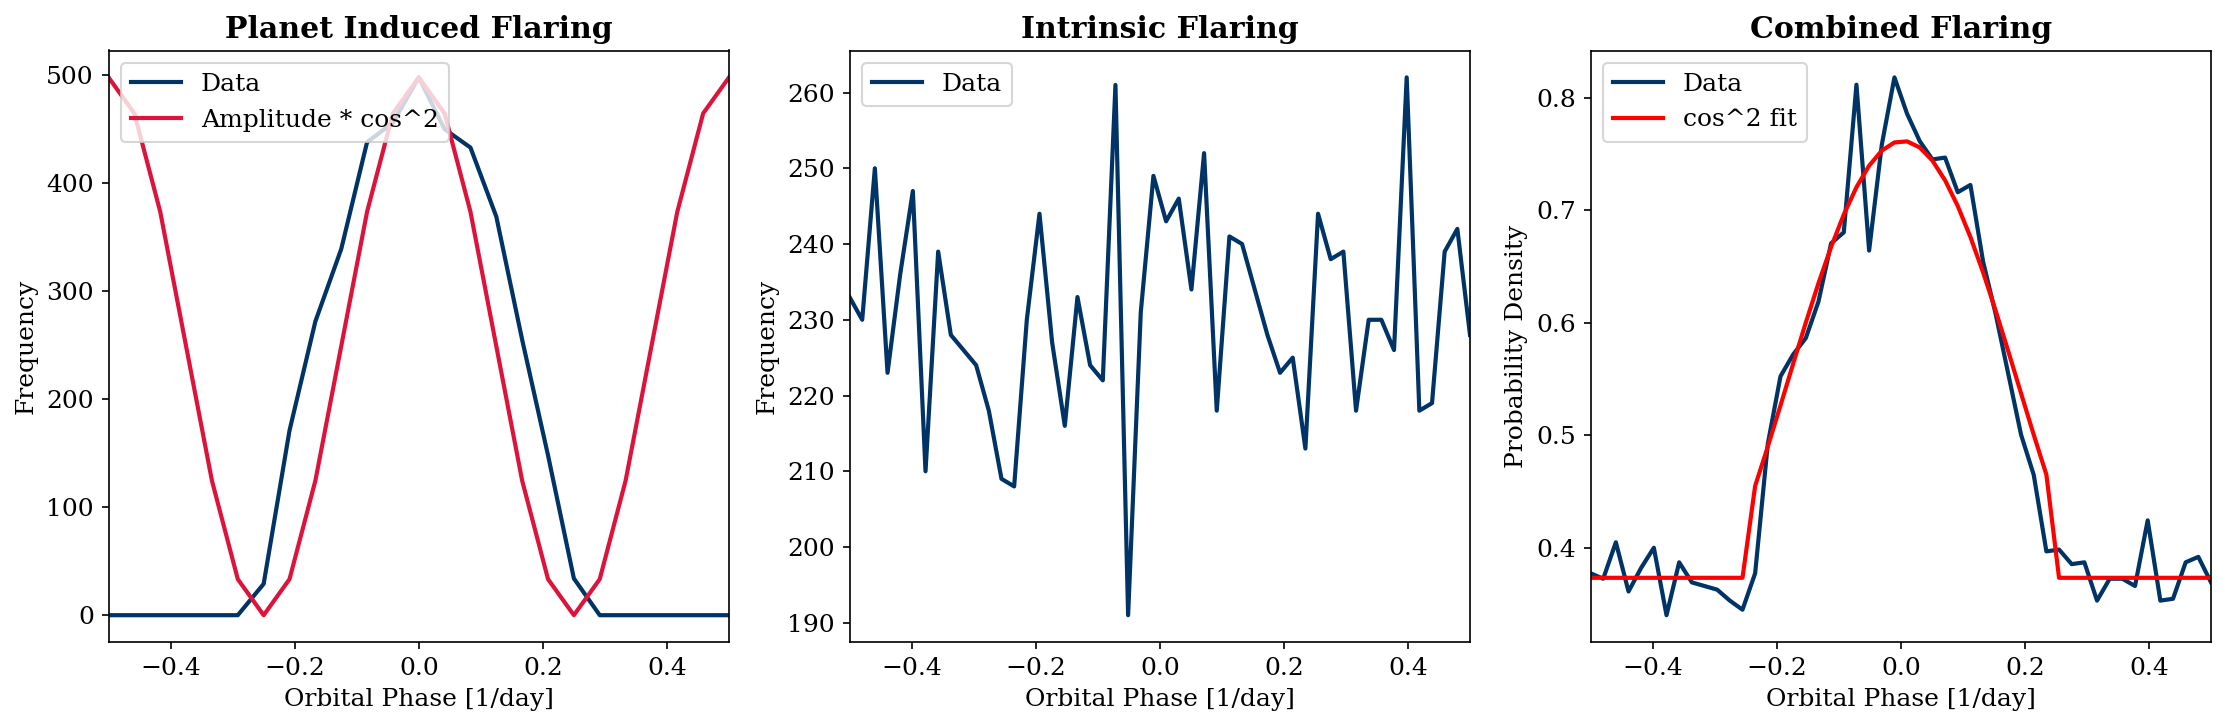

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

x_plot_planet = np.linspace(-0.5,0.5,len(counts_planet))

ax[0].plot(x_plot_planet,counts_planet,color='#003366',lw=2,label='Data')
ax[0].plot(x_plot_planet,np.max(counts_planet)*np.cos(2*np.pi*x_plot_planet)**2,lw=2,color='crimson',label='Amplitude * cos^2')
ax[0].set_xlim(-0.5,0.5)
ax[0].set_xlabel("Orbital Phase [1/day]")
ax[0].set_ylabel("Frequency")
ax[0].set_title(f"Planet Induced Flaring",weight='bold')
ax[0].legend(loc='upper left')

x_plot_intrinsic = np.linspace(-0.5,0.5,len(counts_intrinsic))
ax[1].plot(x_plot_intrinsic,counts_intrinsic,color='#003366',lw=2,label='Data')
ax[1].set_xlim(-0.5,0.5)
ax[1].set_xlabel("Orbital Phase [1/day]")
ax[1].set_ylabel("Frequency")
ax[1].set_title(f"Intrinsic Flaring",weight='bold')
ax[1].legend(loc='upper left')

x_plot_combined = np.linspace(-0.5,0.5,len(counts_combined))
ax[2].plot(x_plot_combined,counts_combined,color='#003366',lw=2,label='Data')
ax[2].plot(x, final_fit, color='red', lw=2, label='cos^2 fit')
ax[2].set_xlim(-0.5,0.5)
ax[2].set_xlabel("Orbital Phase [1/day]")
ax[2].set_ylabel("Probability Density")
ax[2].set_title(f"Combined Flaring",weight='bold')
ax[2].legend(loc='upper left')



plt.tight_layout()
plt.show()

In [23]:
# Function Time!

In [24]:
def create_pdf(intrinsic_flaring_rate,planet_ratio,amount_of_flares,slope,E_thres,e_mix,e_max,plot):
    dt, pdf = PDF_planet_induced(intrinsic_flaring_rate,planet_ratio,amount_of_flares)

    ids = rng.choice(len(dt), size=amount_of_flares)
    selected_ids = ids
    selected_dts = dt[ids]
    
    amount = ((dt[ids] > -0.25) & (dt[ids] < 0.25)).astype(int)
    
    # Finding the flaring rates for the intrinsic areas.
    minimum_id = np.min(selected_ids)
    ratio_unique_flare_rate = pdf[minimum_id]
    
    # Calculating the energy based on the power law
    energy = sample_powerlaw_energies(amount_of_flares, rng, ratio_unique_flare_rate, slope,e_min,e_max)
    
    # Removing all indexes that have E<E_thres
    # Therefore generating a list with Energies > E_thres
    mask = energy >= E_thres
        
    energy_final_intrinsic =  energy[mask]
    dt_final_intrinsic = selected_dts[mask]
    
    # Finding the flaring rates for the planet Induced areas.
    middle_id = int(amount_of_flares/2)
    ratio_unique_flare_rate = pdf[middle_id]
        
    # Calculating the energy based on the power law
    energy = sample_powerlaw_energies(amount_of_flares, rng, ratio_unique_flare_rate, slope,e_min,e_max)
    
    
    # Removing all indexes that have E < E_thres
    # Then removing all dt outside [-0.25, 0.25]
    
    energy_transformed = energy * np.cos(2*np.pi*selected_dts)
    
    # 1) Filter by energy threshold
    mask_energy = energy_transformed >= E_thres
    
    energy_filtered = energy_transformed[mask_energy]
    dt_filtered = selected_dts[mask_energy]
    
    # 2) Filter dt between -0.25 and 0.25
    mask_dt = (dt_filtered >= -0.25) & (dt_filtered <= 0.25)
    
    energy_final_planet = energy_filtered[mask_dt]
    dt_final_planet = dt_filtered[mask_dt]
    
    E_combined = np.concatenate([energy_final_planet,energy_final_intrinsic])
    dt_combined = np.concatenate([dt_final_planet,dt_final_intrinsic])
    
    # First we remove (intrinsic - planet) flares from intrinsic to equal amounts.
    keep_flare_fraction = planet_ratio
        
    keep_flare_number = int(len(dt_final_intrinsic) - (len(dt_final_intrinsic)-len(dt_final_planet)))
        
    selected_ids = np.random.choice(len(dt_final_intrinsic), size=keep_flare_number, replace=False)
    energy_list_selected_intrinsic_final = (energy_final_intrinsic[selected_ids])
    dt_selected_intrinsic = (dt_final_intrinsic[selected_ids])
    
    
    keep_planet_fraction = planet_ratio
        
    keep_planet_number = int(len(dt_final_planet) * keep_planet_fraction)
    keep_intrinsic_number = int(len(dt_final_planet) * (1-keep_planet_fraction))
        
    # Planet
    selected_ids = np.random.choice(len(dt_final_planet), size=keep_planet_number, replace=False)
    energy_kept_planet = (energy_final_planet[selected_ids])
    dt_kept_planet = (dt_final_planet[selected_ids])
        
    # Intrinsic
    selected_ids = np.random.choice(len(dt_final_intrinsic), size=keep_intrinsic_number, replace=False)
    energy_kept_intrinsic = (energy_final_intrinsic[selected_ids])
    dt_kept_intrinsic = (dt_final_intrinsic[selected_ids])
    
    c = np.concatenate([energy_kept_planet,energy_kept_intrinsic])
    d = np.concatenate([dt_kept_planet,dt_kept_intrinsic])
    
    counts_planet, bin_edges = np.histogram(dt_kept_planet, bins=25, range=(-0.5, 0.5))
    counts_intrinsic, bin_edges = np.histogram(dt_kept_intrinsic, bins=50, range=(-0.5, 0.5))
    
    counts, bin_edges = np.histogram(d, bins=50, range=(-0.5, 0.5))
        
    # Normalizing to intrinsic_flaring_rate
    counts_normalized = counts #* intrinsic_flaring_rate
    counts_combined = (counts)
    counts_combined_mean = [np.mean(counts[:10]), np.mean(counts[-10:])]
    
    x_plot_planet = np.linspace(-0.5,0.5,len(counts_planet))
    x_plot_planet_fit = np.linspace(-0.25,0.25,int(len(counts_planet)/2))
    
    cos_slope = np.abs(slope+1)

    baseline = np.mean(counts_combined_mean)
    amp = np.max(counts_combined) - baseline
    model_combined = baseline + amp * np.cos(2 * np.pi * x_plot_combined) ** (cos_slope)
    final_fit = np.where((x_plot_combined < -0.25) | (x_plot_combined > 0.25), baseline, model_combined)
    
    if plot == True:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
        ax[0].plot(x_plot_planet,counts_planet,color='#003366',lw=2,label='Data')
        ax[0].plot(x_plot_planet_fit,np.max(counts_planet)*np.cos(2*np.pi*x_plot_planet_fit)**(cos_slope),lw=2,label=f'cos^{cos_slope} fit',color='crimson',ls='--')
        ax[0].set_xlim(-0.5,0.5)
        ax[0].set_ylim(0)
        ax[0].set_xlabel("Orbital Phase [1/day]")
        ax[0].set_ylabel("Frequency")
        ax[0].set_title(f"Planet Induced Flaring",weight='bold')
        ax[0].legend(loc='upper left')
        
        x_plot_intrinsic = np.linspace(-0.5,0.5,len(counts_intrinsic))
        ax[1].plot(x_plot_intrinsic,counts_intrinsic,color='#003366',lw=2,label='Data')
        ax[1].set_xlim(-0.5,0.5)
        ax[1].set_xlabel("Orbital Phase [1/day]")
        ax[1].set_ylabel("Frequency")
        ax[1].set_title(f"Intrinsic Flaring",weight='bold')
        ax[1].legend(loc='upper left')
    
        ax[2].plot(x_plot_combined,counts_combined,color='#003366',lw=2,label='Data')
        ax[2].plot(x_plot_combined,final_fit,lw=2,label=f'Model Fit',color='crimson',ls='--')
        ax[2].set_xlim(-0.5,0.5)
        ax[2].set_xlabel("Orbital Phase [1/day]")
        ax[2].set_ylabel("Probability Density")
        ax[2].set_title(f"Combined Flaring",weight='bold')
        ax[2].legend(loc='upper left')
    
    
    
        plt.tight_layout()
        plt.show()

    normalized_final_fit = (final_fit/np.sum(final_fit))*intrinsic_flaring_rate
    
    return counts_planet,counts_intrinsic,counts,final_fit,normalized_final_fit

In [25]:
slope = -2
amount_of_flares = int(1e6)
intrinsic_flaring_rate = 0.25
planet_ratio = 0.25

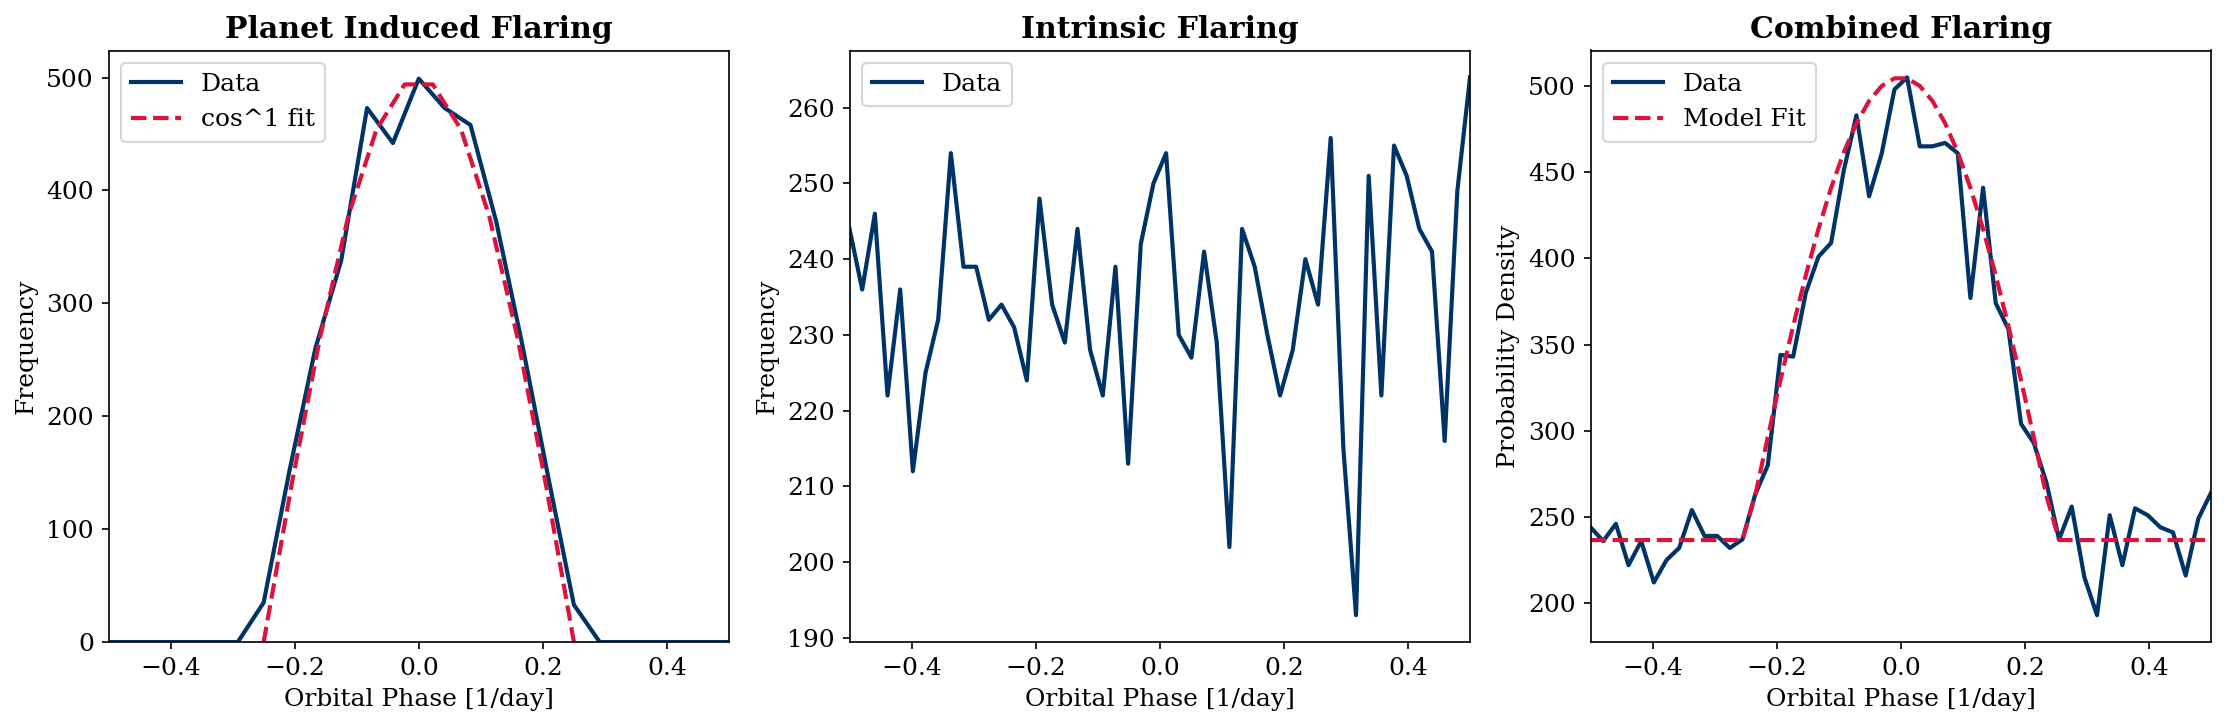

In [26]:
counts_planet,counts_intrinsic,counts,final_fit,normalized_final_fit = create_pdf(intrinsic_flaring_rate,planet_ratio,amount_of_flares,slope,E_thres,e_min,e_max,plot=True)

In [27]:
p = []
m = []
n = []

ratios = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in ratios:
    counts_planet,counts_intrinsic,counts,final_fit,normalized_final_fit = create_pdf(intrinsic_flaring_rate,i,amount_of_flares,slope,E_thres,e_min,e_max,plot=False)
    p.append(normalized_final_fit)
    m.append(counts)
    n.append(final_fit)


A cosine plus a constant has broader wings than a pure cosine scaled to the same peak. So if you scale the pure cosine to the max of the combined counts, the model drops too fast in the wings → it looks “too narrow” compared to the actual histogram. That’s exactly what you’re seeing.

In [28]:
# fig, ax = plt.subplots(1, len(ratios), figsize=(len(ratios)*5, len(ratios)))
# x = np.arange(-0.5,0.5,1/50)
# e = []
# for i in range(len(p)):

#     expected = n[i] * (m[i].sum() / n[i].sum())

#     # Chi-square test
#     chi2_stat, p_value = chisquare(f_obs=m[i], f_exp=expected)

    
#     ax[i].plot(x,n[i]/np.sum(n[i]),color='crimson',lw=2)
#     ax[i].plot(x,m[i]/np.sum(m[i]),color='#003366',lw=2)
#     ax[i].set_ylim(0,0.08)
#     ax[i].set_xlabel("Orbital Phase [1/day]")
#     ax[i].set_ylabel("Probability Density")
#     ax[i].set_title(f"Planet Ratio: {ratios[i]}",weight='bold')
#     ax[i].text(0.01, 0.99,f'chi2: {chi2_stat:.3f}, p_val: {p_value:.3f}',transform=ax[i].transAxes,ha='left',va='top')
# plt.tight_layout()
# plt.show()

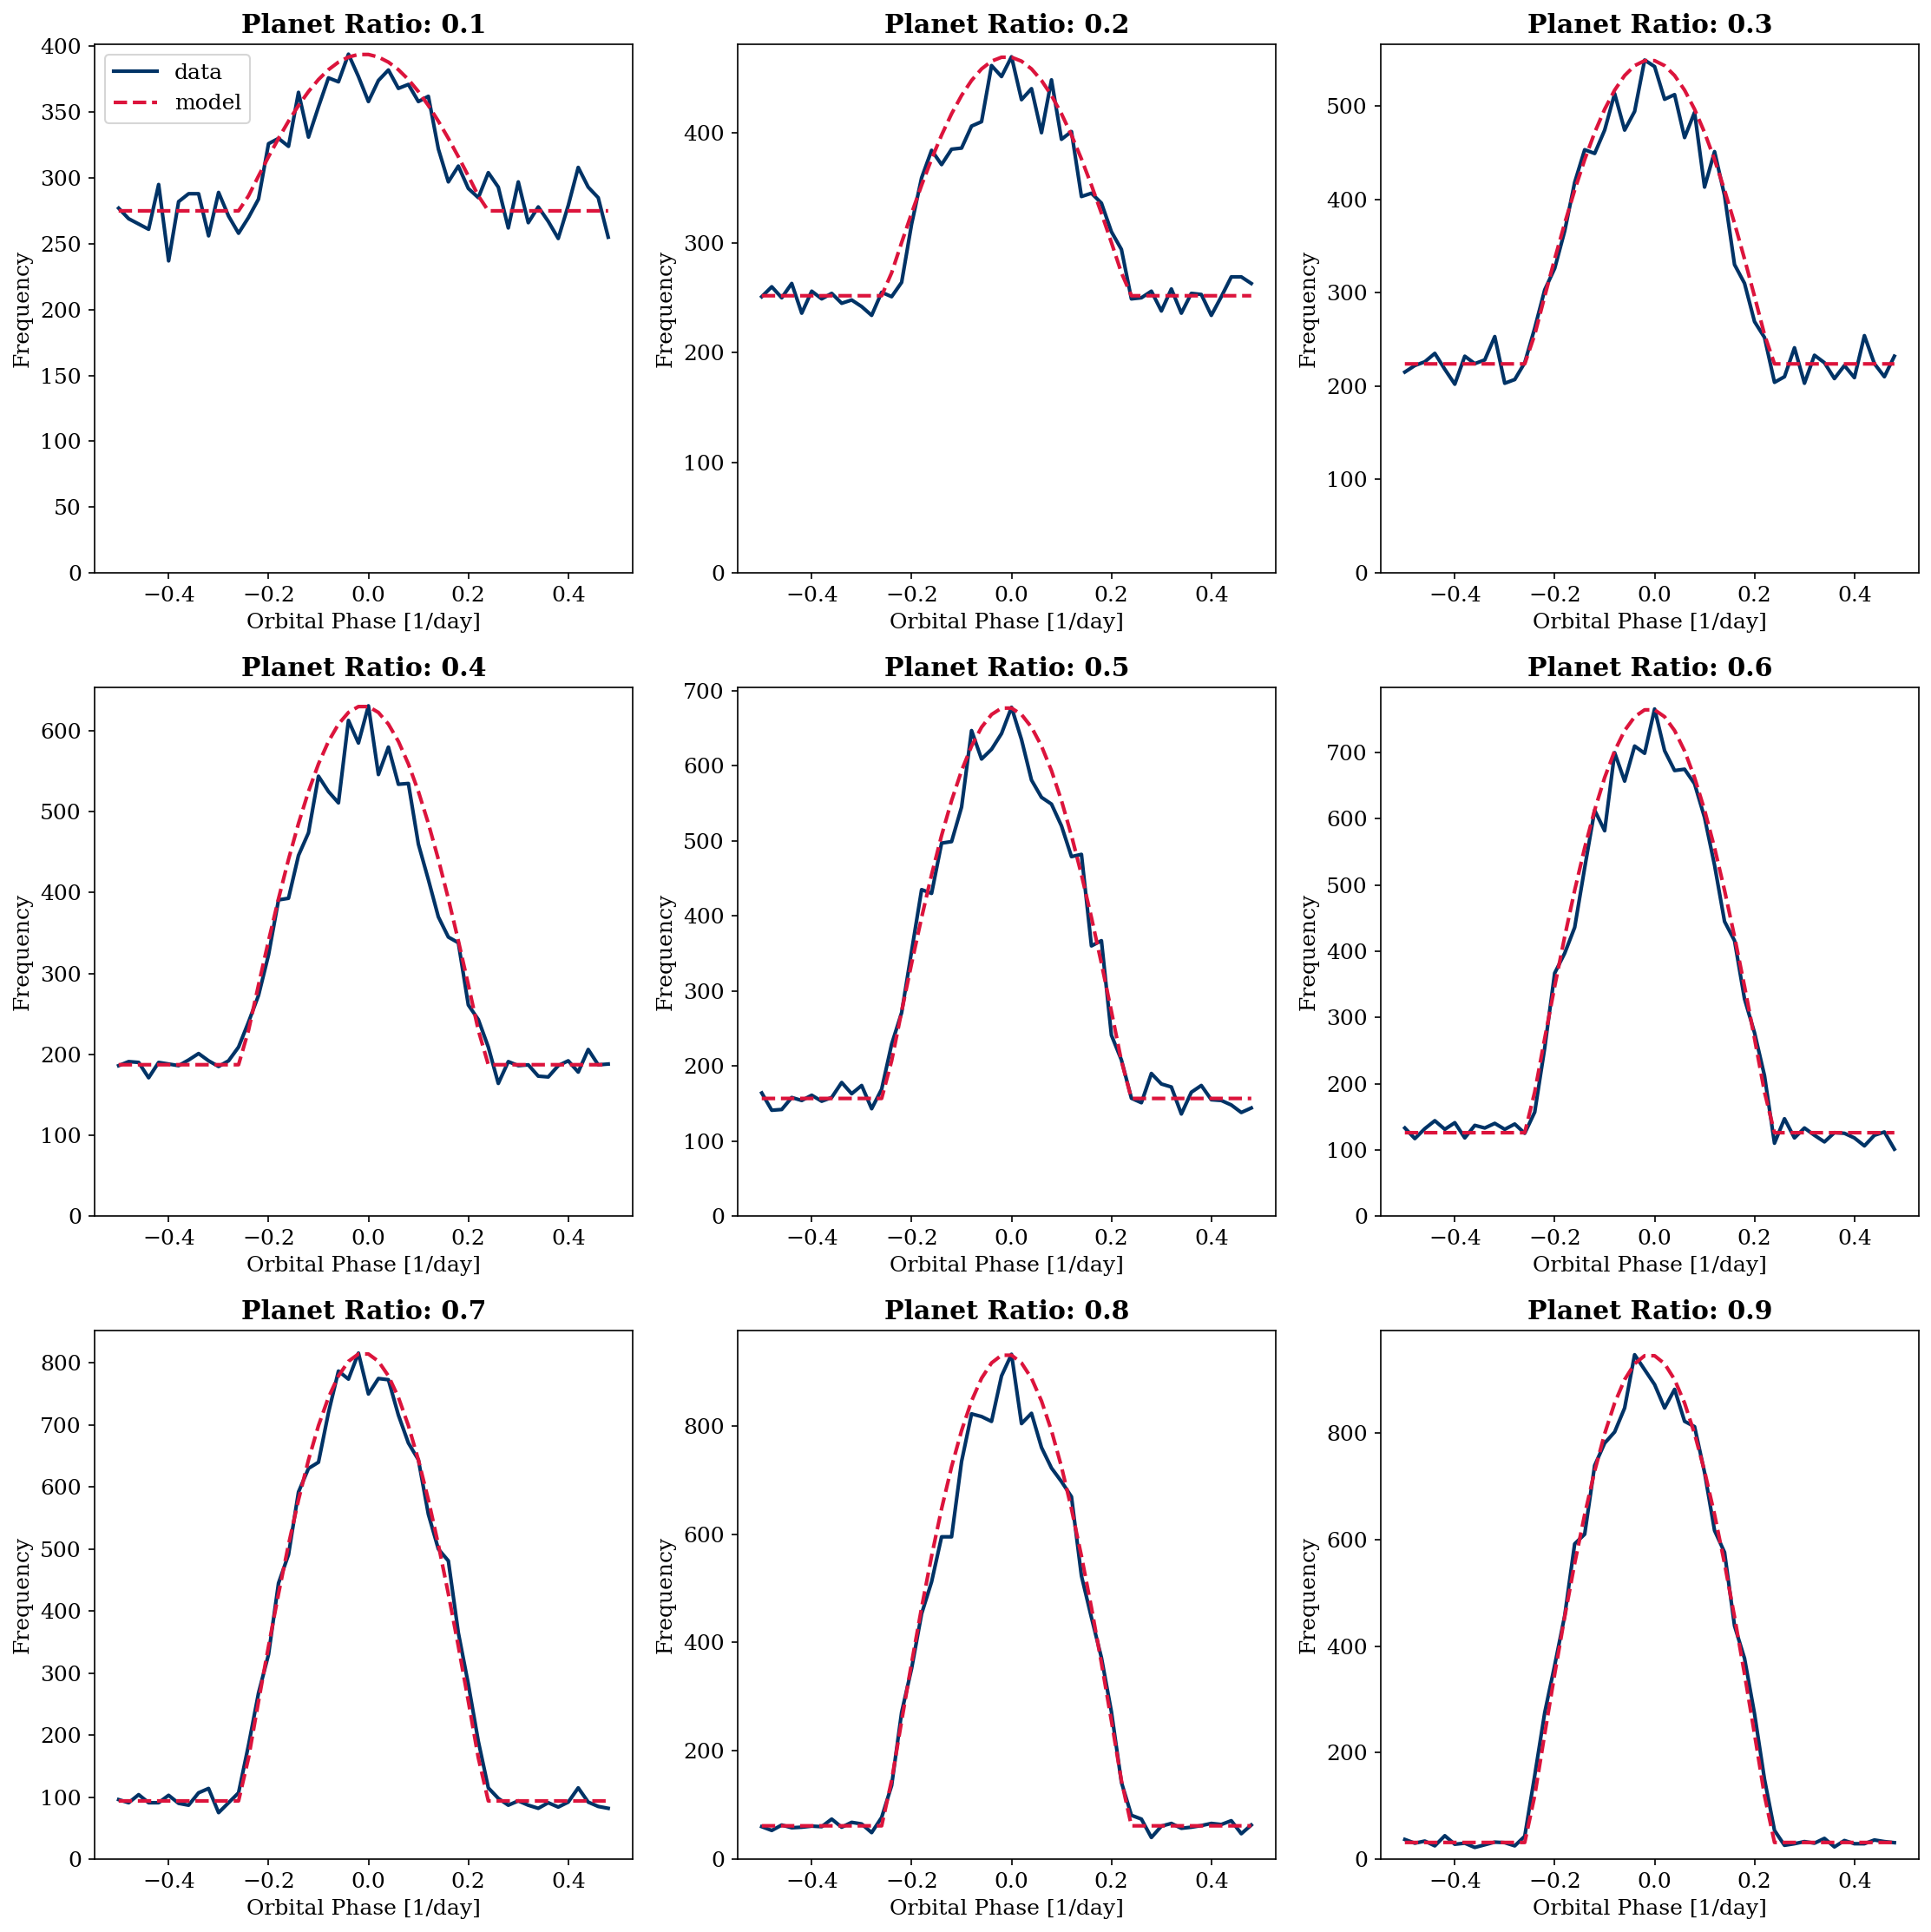

In [29]:
rows, cols = 3, 3  

fig, ax = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
ax = ax.flatten() 

x = np.arange(-0.5, 0.5, 1/50)

for i in range(len(p)):
    ax[i].plot(x, m[i], color='#003366', lw=2,label='data')
    ax[i].plot(x, n[i], color='crimson', lw=2,label='model',ls='--')
    ax[i].set_xlabel("Orbital Phase [1/day]")
    ax[i].set_ylabel("Frequency")
    ax[i].set_ylim(0)
    ax[i].set_title(f"Planet Ratio: {ratios[i]}", weight='bold')
    if i == 0:
        ax[i].legend(loc='upper left')
plt.tight_layout()
plt.show()

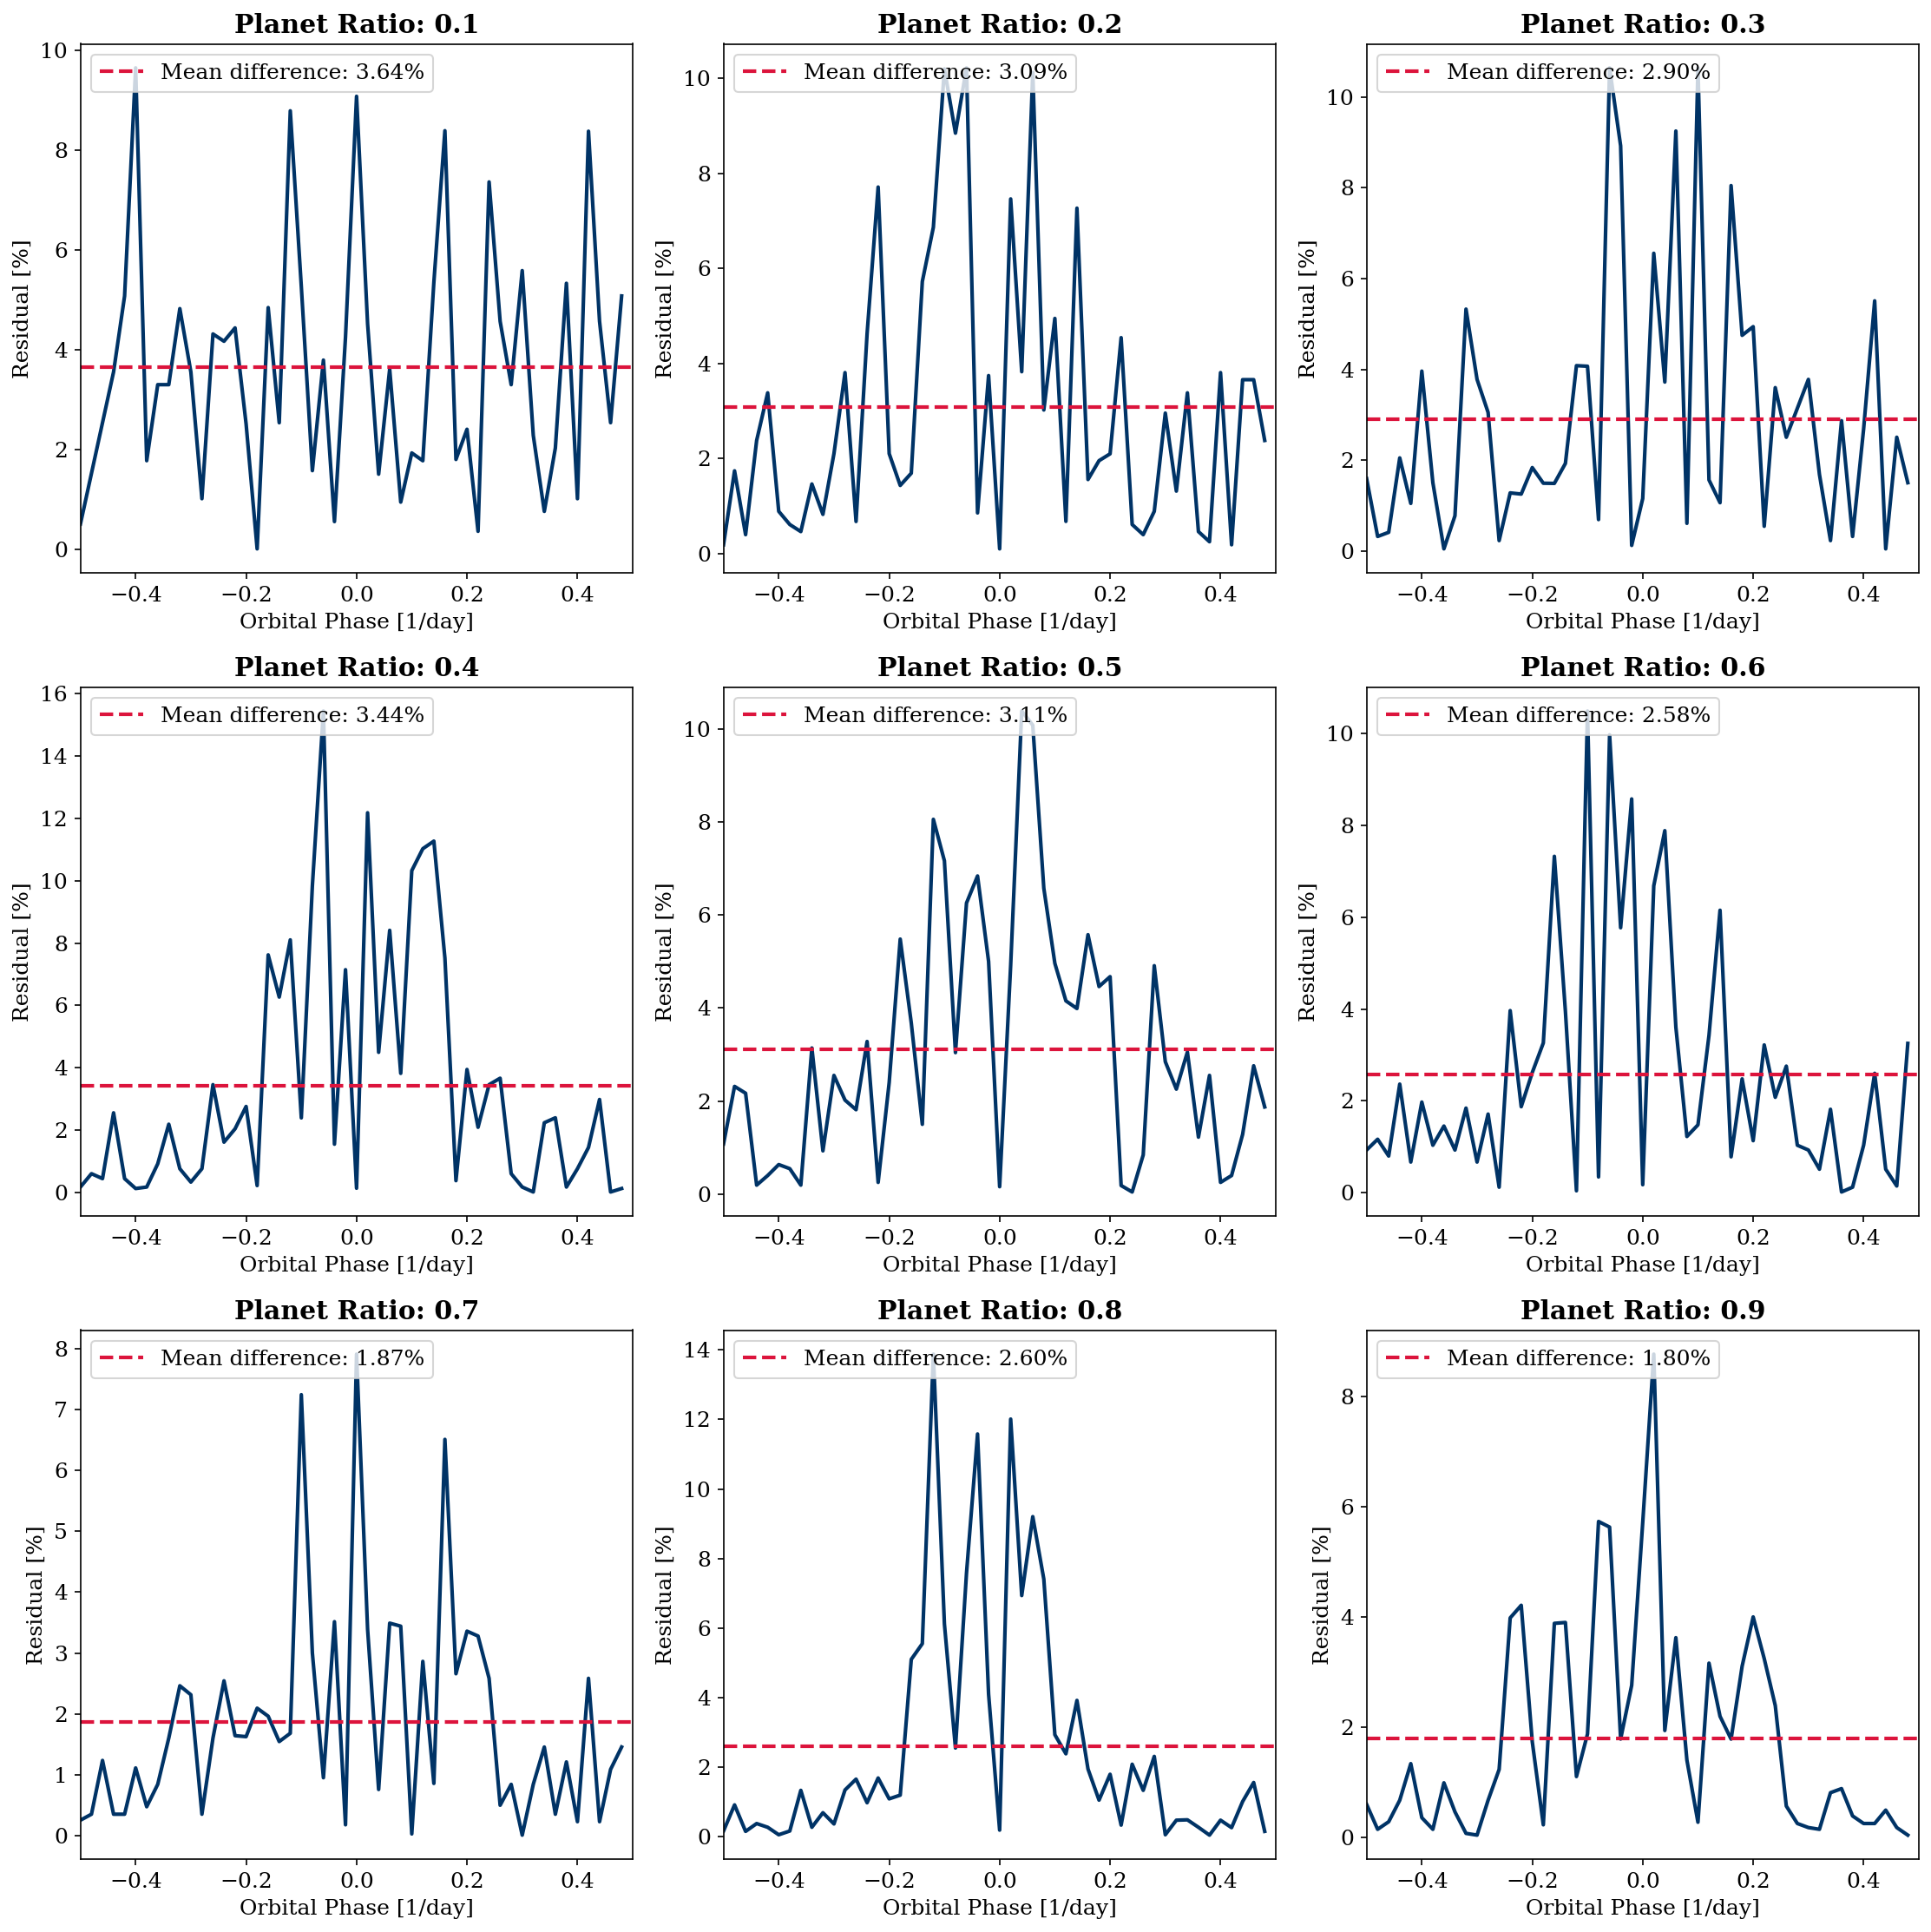

In [30]:
rows, cols = 3, 3  

fig, ax = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
ax = ax.flatten()  

x = np.arange(-0.5, 0.5, 1/50)
for i in range(len(p)):
    res = np.abs(n[i]-m[i])/np.max(np.maximum(n[i],m[i]))*100
    
    ax[i].plot(x,res, color='#003366', lw=2)
    ax[i].axhline(np.mean(res),color='crimson',lw=2,ls='--',label=f'Mean difference: {np.mean(res):.2f}%')
    ax[i].set_xlim(-0.5,0.5)
    ax[i].set_xlabel("Orbital Phase [1/day]")
    ax[i].set_ylabel("Residual [%]")
    ax[i].set_title(f"Planet Ratio: {ratios[i]}", weight='bold')
    ax[i].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [31]:
def pairwise_waiting_times(timeseries):
    """
    Compute all pairwise waiting times from a sequence of time points.

    Given an iterable of time values (e.g., event timestamps), this function
    calculates the difference between every pair of times where the second
    time occurs after the first. In other words, for each pair (i, j) with
    j > i, it computes times[j] - times[i].

    Parameters
    ----------
    timeseries : iterable of numbers
        A sequence of time points (e.g., [t0, t1, t2, ...]) representing when events occur.

    Returns
    -------
    list of numbers
        A list of all positive time differences between pairs of time points.
        The list length is n*(n-1)/2 for n input times."""
    t = list(timeseries)
    return [t[j] - t[i] for i in range(len(t)) for j in range(i+1, len(t))]

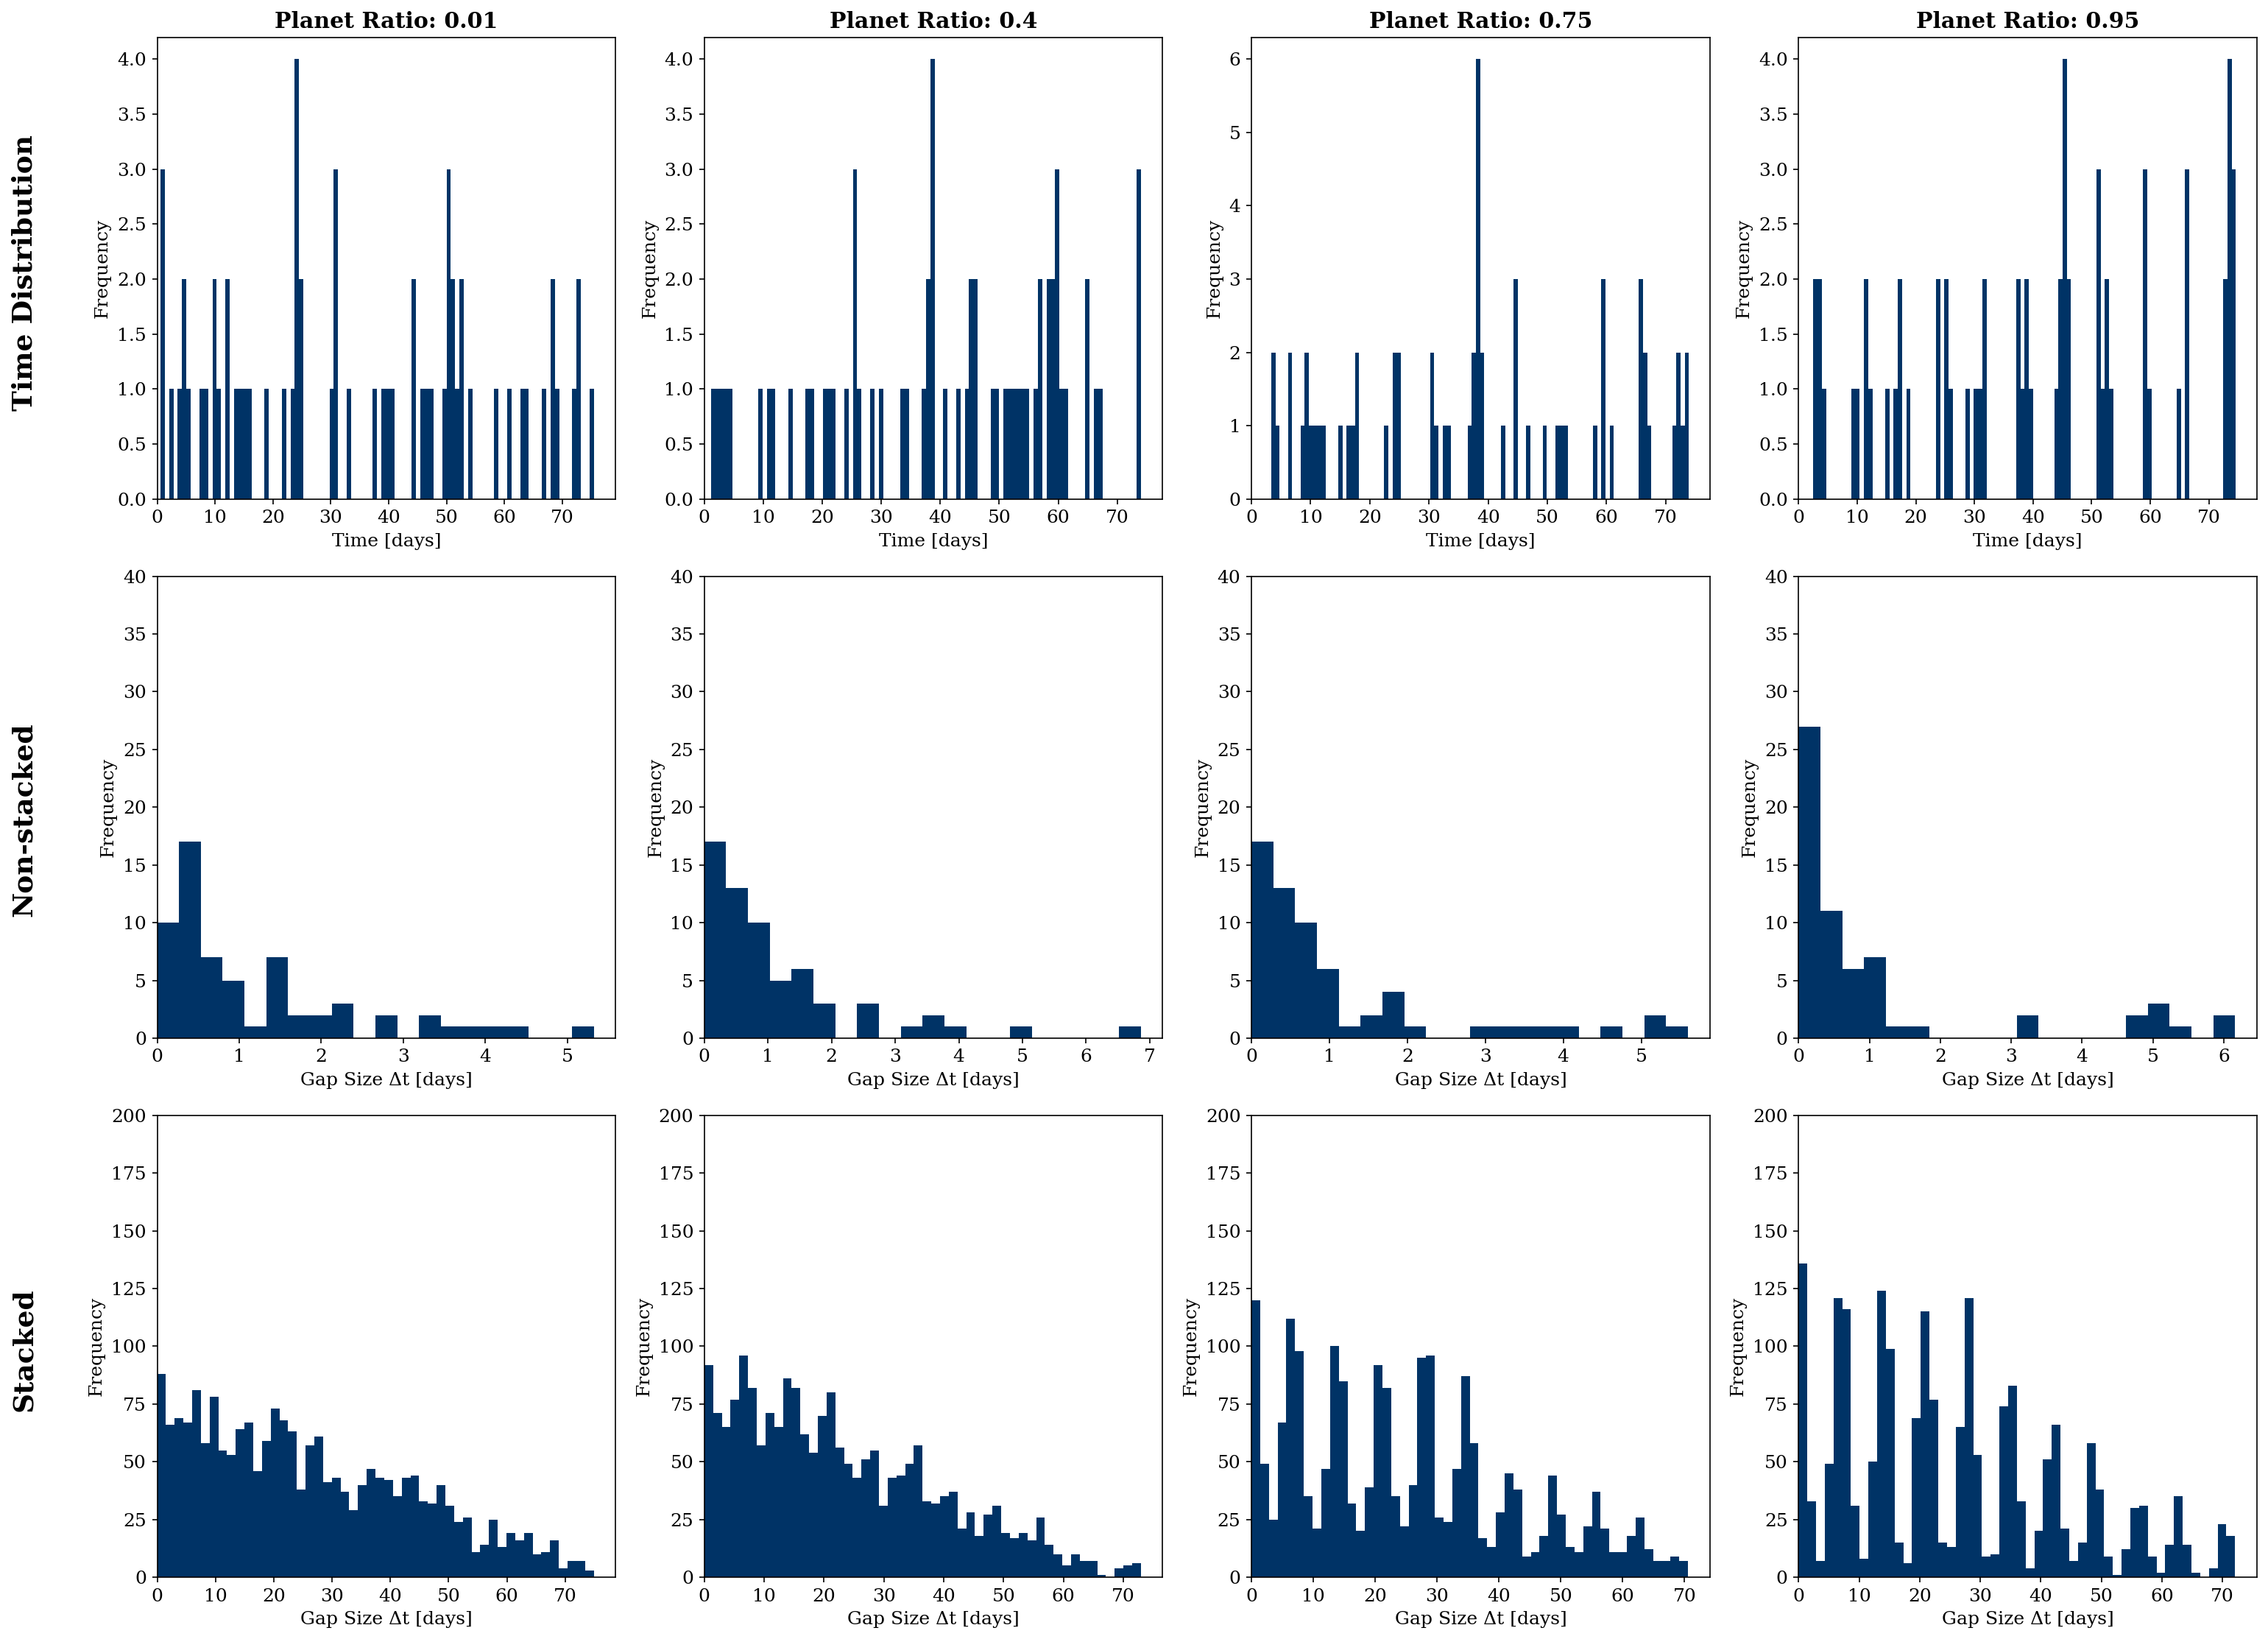

In [32]:
slope = -2
amount_of_flares = int(1e6)
intrinsic_flaring_rate = 0.8
planet_ratio = [0.01,0.4,0.75,0.95]
total_observing_time = 81 #days
Period = 7 # days

fig, ax = plt.subplots(3, 4, figsize=(4*5, 15))


for i in range(len(planet_ratio)):    

    counts_planet,counts_intrinsic,counts,final_fit,normalized_final_fit = create_pdf(intrinsic_flaring_rate,planet_ratio[i],amount_of_flares,slope,E_thres,e_min,e_max,plot=False)
    
    
    number_simulated_flares = total_observing_time*intrinsic_flaring_rate
    
    # Number of flares to simulate over the total observing time
    number_simulated_flares = int(total_observing_time * intrinsic_flaring_rate)
    
    # How many periods fit in the total observing time
    n_periods = int(total_observing_time / Period)
    
    # Stack (tile) the normalized PDF n_periods times
    stacked_pdf = np.tile(normalized_final_fit, n_periods)
    
    # Just in case: re-normalize to ensure it sums to 1
    stacked_pdf = stacked_pdf / stacked_pdf.sum()
    
    # Randomly draw 'number_simulated_flares' flares from this stacked PDF
    # This returns indices in the stacked PDF
    selected_indices = np.random.choice(len(stacked_pdf),size=number_simulated_flares,p=stacked_pdf)
    
    Flare_times = Period*selected_indices/50

    diff = np.diff(np.sort(Flare_times))
    diff2 = pairwise_waiting_times(np.sort(Flare_times))
    
    ax[0,i].hist(Flare_times,bins=100, color='#003366')
    ax[0,i].set_ylabel('Frequency')
    ax[0,i].set_xlabel('Time [days]')
    ax[0,i].set_title(f'Planet Ratio: {planet_ratio[i]}',weight='bold')
    ax[0,i].set_xlim(0)
    
    ax[1,i].hist(diff,bins=20, color='#003366')
    ax[1,i].set_ylabel('Frequency')
    ax[1,i].set_xlabel('Gap Size Δt [days]')
    ax[1,i].set_xlim(0)
    ax[1,i].set_ylim(0,40)
    
    ax[2,i].hist(diff2,bins=50, color='#003366')
    ax[2,i].set_ylabel('Frequency')
    ax[2,i].set_xlabel('Gap Size Δt [days]')
    ax[2,i].set_xlim(0)
    ax[2,i].set_ylim(0,200)


# fig.text(-0.04, 0.80, 'Time Distribution', va='center', rotation='vertical', fontsize=12)
# fig.text(-0.04, 0.50, 'Non-stacked',       va='center', rotation='vertical', fontsize=12)
# fig.text(-0.04, 0.20, 'Stacked',           va='center', rotation='vertical', fontsize=12)

fig.text(-0.02, 0.83, 'Time Distribution', ha='center', va='center', rotation='vertical', fontsize=18, weight='bold')
fig.text(-0.02, 0.50, 'Non-stacked', ha='center', va='center', rotation='vertical', fontsize=18, weight='bold')
fig.text(-0.02, 0.18, 'Stacked', ha='center', va='center', rotation='vertical', fontsize=18, weight='bold')
plt.tight_layout()
plt.show()
    

In [36]:
def Fake_data(intrinsic_flaring_rate,planet_ratio,amount_of_flares,slope,E_thres,e_min,e_max,total_observing_time,Period,plot=False):
    """
    Generate synthetic stellar flare times using a probability distribution
    derived from an intrinsic flaring rate and optional planetary modulation.

    Parameters
    ----------
    intrinsic_flaring_rate : float
        Average number of intrinsic flares per unit time.
    planet_ratio : float
        Fractional modulation amplitude due to a planet (0–1).
    amount_of_flares : int
        Number of flares used to build the initial PDF.
    slope : float
        Slope parameter used inside `create_pdf` when generating energy PDFs.
    E_thres : float
        Energy threshold applied when generating the flare distribution.
    e_min : float
        Minimum flare energy.
    e_max : float
        Maximum flare energy.
    total_observing_time : float
        total simulated observing time.
    Period : float
        Orbital period of the planet, used to stack periodic flare PDFs.
    plot : bool, optional
        If True, plotting is enabled in `create_pdf`. Default is False.

    Returns
    -------
    Flare_times_sorted : numpy.ndarray
        A sorted 1D array of simulated flare times within the observing window.
    """
    
    
    # ---------- PRECONDITION CHECKS ----------
    # Basic numeric sanity
    assert intrinsic_flaring_rate > 0, "intrinsic_flaring_rate must be > 0."
    assert total_observing_time > 0, "total_observing_time must be > 0."
    assert Period > 0, "Period must be > 0."
    assert amount_of_flares > 0, "amount_of_flares must be > 0."

    # Energies
    assert e_min < e_max, "e_min must be strictly smaller than e_max."
    assert E_thres >= e_min, "E_thres should be >= e_min."
    assert E_thres <= e_max, "E_thres should be <= e_max."

    # Planet ratio
    assert 0 <= planet_ratio <= 1, "planet_ratio should be between 0 and 1."

    # Ensure at least one period fits in the observing time
    assert total_observing_time >= Period, ("total_observing_time must be at least one Period (otherwise no complete orbit fits).")

    # ---------- CORE COMPUTATION ----------
    counts_planet, counts_intrinsic, counts, final_fit, normalized_final_fit = create_pdf(intrinsic_flaring_rate,planet_ratio,amount_of_flares,slope,E_thres,e_min,e_max,plot=False,)

    # Invariant about the PDF we just got
    assert isinstance(normalized_final_fit, np.ndarray),"normalized_final_fit must be a numpy array."
    assert normalized_final_fit.ndim == 1, "normalized_final_fit must be 1D."
    assert np.all(normalized_final_fit >= 0), "normalized_final_fit must be non-negative."

    # Number of flares to simulate over the total observing time
    number_simulated_flares = int(total_observing_time * intrinsic_flaring_rate)
    assert number_simulated_flares > 0, ("total_observing_time * intrinsic_flaring_rate must be >= 1,to simulate at least one flare.")

    # How many periods fit in the total observing time
    n_periods = int(total_observing_time / Period)
    assert n_periods > 0, "n_periods must be >= 1."

    # Stack the normalized PDF n_periods times
    stacked_pdf = np.tile(normalized_final_fit, n_periods)

    # Normalize to ensure it sums to 1
    stacked_pdf_sum = np.sum(stacked_pdf)
    assert stacked_pdf_sum > 0, "stacked_pdf must have positive total probability."
    
    stacked_pdf = stacked_pdf / stacked_pdf_sum

    # Check that it is a proper probability distribution
    assert np.isclose(stacked_pdf.sum(), 1.0, rtol=1e-6, atol=1e-9),"stacked_pdf must sum to 1 after renormalization."
    assert np.all(stacked_pdf >= 0), "stacked_pdf must be non-negative."

    # Randomly draw 'number_simulated_flares' flares from this stacked PDF
    selected_indices = np.random.choice(len(stacked_pdf),size=number_simulated_flares,p=stacked_pdf,)
    assert len(selected_indices) == number_simulated_flares,"Number of selected indices must match number_simulated_flares."

    # Convert indices to times
    Flare_times = Period * selected_indices / 50.0
    assert Flare_times.shape[0] == number_simulated_flares,"Flare_times must have one entry per simulated flare."

    # Times should not exceed the total observing time by design
    assert Flare_times.min() >= 0, "Flare times must be non-negative."
    assert Flare_times.max() <= total_observing_time + 1e-8,"Max flare time should not exceed total_observing_time."

    Flare_times_sorted = np.sort(Flare_times)

    # ---------- POSTCONDITION CHECKS ----------
    # Sorted output
    assert np.all(np.diff(Flare_times_sorted) >= 0),"Flare_times_sorted must be non-decreasing."

    # Length consistency
    assert len(Flare_times_sorted) == number_simulated_flares,"Output length must equal number_simulated_flares."

    # Same bounds after sorting
    assert Flare_times_sorted[0] >= 0, "First flare time must be >= 0."
    assert Flare_times_sorted[-1] <= total_observing_time + 1e-8,"Last flare time must be within total_observing_time."

    # --- SAVE WITH COLUMN NAME "t_flare" ---
    out_dir = "../Data & Results/Fake-Data"
    os.makedirs(out_dir, exist_ok=True)  # Ensure directory exists

    df = pd.DataFrame({"t_flare": Flare_times_sorted})
    df.to_csv(f"../Data & Results/Fake-Data-Test/{intrinsic_flaring_rate:.3f},{planet_ratio:.3f}.txt",index=False)

    # Final postcondition: make sure we are returning what we claim
    assert isinstance(Flare_times_sorted, np.ndarray), "Function must return a numpy array of flare times."

    return Flare_times_sorted


In [39]:
slope = -2
amount_of_flares = int(1e5)


stepsize = 0.001
mean_flaring_rate = np.arange(0.01,1,stepsize)
planet_ratio = np.arange(0.01,1,stepsize)




total_observing_time = 100 #days, arbitrary
Period = 7 # days, arbitrary

# Exporting All fake Data. 

Only run if nessecairy!

In [40]:
start_time = time.time()

for mfr in tqdm(mean_flaring_rate, desc="MFR loop"):
    for pr in planet_ratio:
        Flare_times_sorted = Fake_data(mfr, pr, amount_of_flares, slope, E_thres,e_min, e_max, total_observing_time, Period,plot=False)

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

MFR loop: 100%|██████████| 990/990 [2:25:07<00:00,  8.80s/it]  

Total runtime: 8707.69 seconds


## Importing the data again and preforming a sanity check

MFR loop: 100%|██████████| 990/990 [34:35<00:00,  2.10s/it]


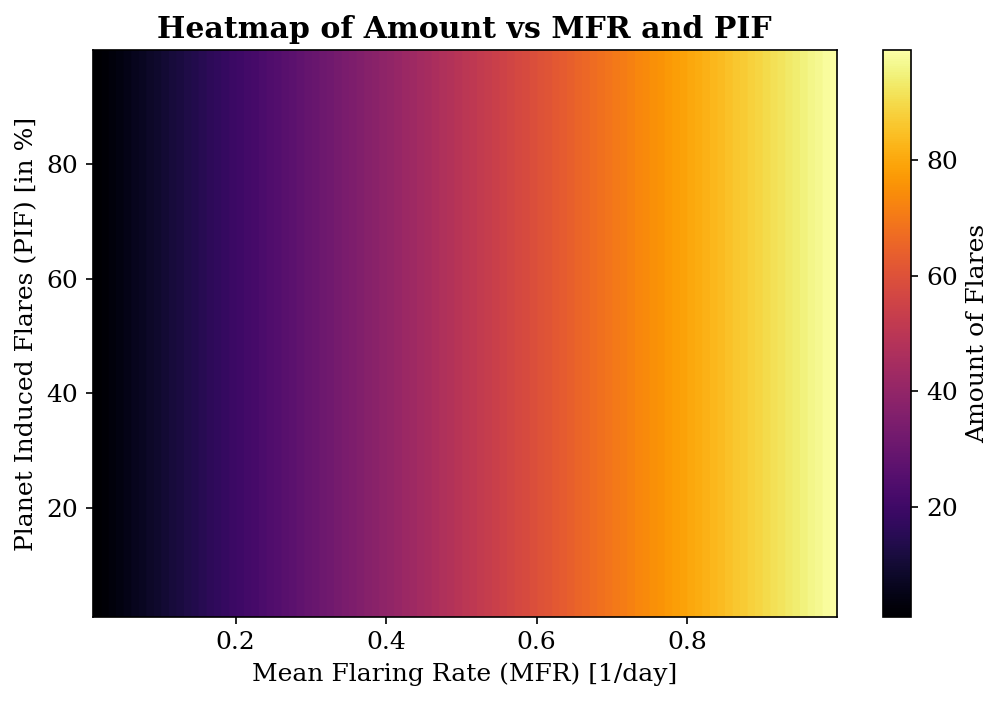

In [42]:
# Prepare a 2D array: rows = PR, columns = IFR
heatmap = np.zeros((len(planet_ratio), len(mean_flaring_rate)))

# Fill heatmap
for i, mfr in enumerate(tqdm(mean_flaring_rate, desc="MFR loop")):
    for j, pr in enumerate(planet_ratio):
        
        file_path = f"../Data & Results/Fake-Data-Test/{mfr:.3f},{pr:.3f}.txt"
        data_flares = pd.read_csv(file_path)

        # Convert / sort
        data_flares["t"] = np.sort(data_flares["t_flare"].values)

        # Count number of flares
        amount = len(data_flares["t_flare"])

        # Store in heatmap array
        heatmap[j, i] = amount


# ---- Plot the heatmap ----
plt.figure(figsize=(8, 5))
plt.imshow(heatmap, origin="lower", aspect="auto",extent=[        
        min(mean_flaring_rate), max(mean_flaring_rate),
        min(planet_ratio)*100,          max(planet_ratio)*100],cmap="inferno")

plt.colorbar(label="Amount of Flares")
plt.xlabel("Mean Flaring Rate (MFR) [1/day]")
plt.ylabel("Planet Induced Flares (PIF) [in %]")
plt.title("Heatmap of Amount vs MFR and PIF", weight='bold')

plt.show()